In [181]:
import os
import random
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.rcParams['figure.figsize'] = [5, 5]
# matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [182]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [192]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '../datasets/dl2020'
annotation_csv = '../datasets/dl2020/annotation_newfeat_3.csv'

In [193]:
anno = pd.read_csv(annotation_csv)

In [194]:
anno.columns

Index(['Unnamed: 0', 'scene', 'sample', 'action', 'category', 'fl_x', 'fr_x',
       'bl_x', 'br_x', 'fl_y', 'fr_y', 'bl_y', 'br_y', 'category_id',
       'action_id', 'new_scene', 'front_left', 'front', 'front_right',
       'back_left', 'back', 'back_right', 'distance', 'center_x', 'center_y',
       'box_width', 'box_height', 'scaled_x', 'scaled_y', 'scaled_box_width',
       'scaled_box_height', 'bev_x', 'bev_y', 'bev_box_width',
       'bev_box_height'],
      dtype='object')

In [195]:
anno.head()

,Unnamed: 0,scene,sample,action,category,fl_x,fr_x,bl_x,br_x,fl_y,...,box_width,box_height,scaled_x,scaled_y,scaled_box_width,scaled_box_height,bev_x,bev_y,bev_box_width,bev_box_height
0,0,111,0,object_action_driving_straight_forward,car,-14.270185,-14.286638,-9.696476,-9.712929,19.254325,...,4.590162,1.919246,246.848277,144.022185,44.065552,14.682233,257.133622,188.264293,45.901617,19.192461
1,1,111,0,object_action_parked,car,-5.902891,-5.657694,-1.628863,-1.383666,29.164061,...,4.519225,2.424500,327.332247,68.645895,43.384560,18.547429,340.971091,89.733196,45.192250,24.245005
2,2,111,0,object_action_walking,pedestrian,37.068518,36.283792,37.300167,36.515442,-20.233128,...,1.016375,1.106252,732.324403,452.320605,9.757203,8.462828,762.837920,591.268765,10.163753,11.062520
3,3,111,0,object_action_driving_straight_forward,car,1.972478,1.988930,-2.744222,-2.727770,8.132214,...,4.733153,1.920518,357.655465,243.788566,45.438265,14.691959,372.557776,318.677864,47.331526,19.205176
4,4,111,0,object_action_driving_straight_forward,car,39.051316,39.067769,34.334616,34.351068,5.287296,...,4.733153,1.920518,713.612314,265.552188,45.438265,14.691959,743.346160,347.127043,47.331526,19.205176


In [196]:
example = anno[anno['category_id'] == 8]

In [197]:
example.head()

,Unnamed: 0,scene,sample,action,category,fl_x,fr_x,bl_x,br_x,fl_y,...,box_width,box_height,scaled_x,scaled_y,scaled_box_width,scaled_box_height,bev_x,bev_y,bev_box_width,bev_box_height
24453,24453,107,14,object_action_walking,animal,14.013089,13.999948,13.427134,13.413992,10.383758,...,0.599097,0.256925,512.774326,226.300988,5.751329,1.965475,534.139923,295.818285,5.990968,2.569248
24457,24457,107,15,object_action_walking,animal,13.068930,13.055947,12.482934,12.469951,10.428298,...,0.598978,0.256544,503.711534,225.963060,5.750192,1.962560,524.699515,295.376549,5.989784,2.565438
24461,24461,107,16,object_action_walking,animal,12.214721,12.202064,11.628682,11.616025,10.443321,...,0.598696,0.255702,495.513839,225.854847,5.747484,1.956117,516.160249,295.235094,5.986963,2.557015
24474,24474,107,18,object_action_walking,animal,10.618526,10.606740,10.032358,10.020571,10.529322,...,0.597955,0.253450,480.197486,225.214407,5.740368,1.938890,500.205714,294.397918,5.979550,2.534496
24476,24476,107,19,object_action_walking,animal,9.932528,9.921125,9.346304,9.334901,10.582343,...,0.597627,0.252497,473.615048,224.816318,5.737220,1.931606,493.349009,293.877540,5.976271,2.524975


In [198]:
# 'other_vehicle': 0,
# 'bicycle': 1,
# 'car': 2,
# 'pedestrian': 3,
# 'truck': 4,
# 'bus': 5,
# 'motorcycle': 6,
# 'emergency_vehicle': 7,
# 'animal': 8

In [199]:
labeled_scene_index = np.arange(132, 134)

transform = torchvision.transforms.ToTensor()

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)


In [200]:
sample_cat, sample, target, road_image, extra = iter(trainloader).next()

In [201]:
print(torch.stack(sample_cat).shape)

torch.Size([2, 3, 1536, 306])


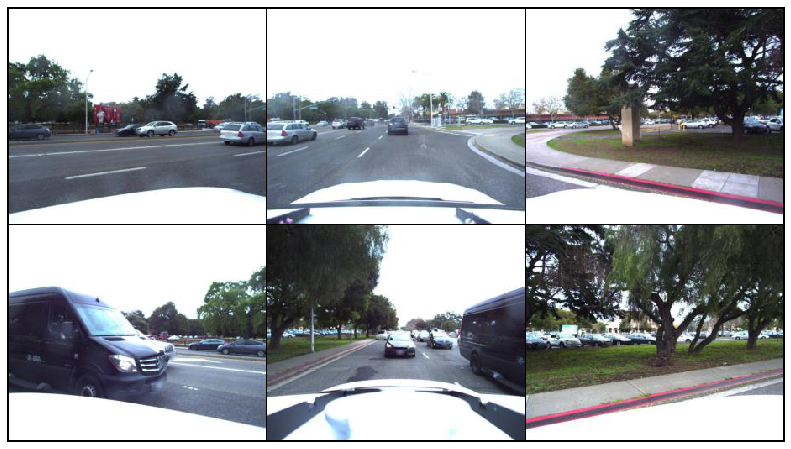

In [202]:
plt.figure(figsize=(20,8))
plt.imshow(torchvision.utils.make_grid(torch.stack(sample)[0], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

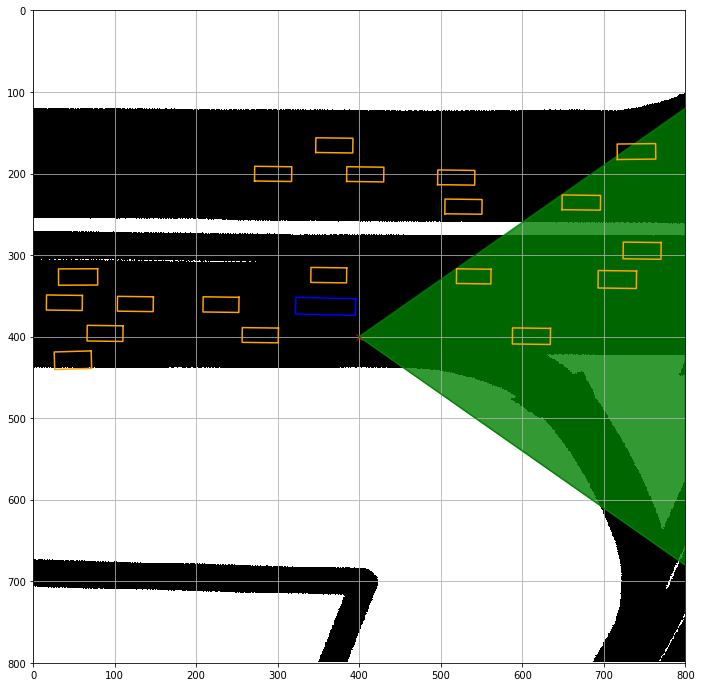

In [203]:
# The center of image is 400 * 400

fig, ax = plt.subplots(figsize=(12,12))



color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']



ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

x = np.arange(400, 800)
y1 = 400 - math.tan(math.pi*(35/180))*(x-400)
y2 = 400 + math.tan(math.pi*(35/180))*(x-400)
ax.plot(x, y1, color = 'green', alpha = 0.8)
ax.plot(x, y2, color = 'green', alpha = 0.8)
ax.fill_between(x, y1, y2, color = 'green', alpha = 0.8)
ax.set_xlim([0, 800])
ax.set_ylim([800, 0])


for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])   
    
ax.grid()

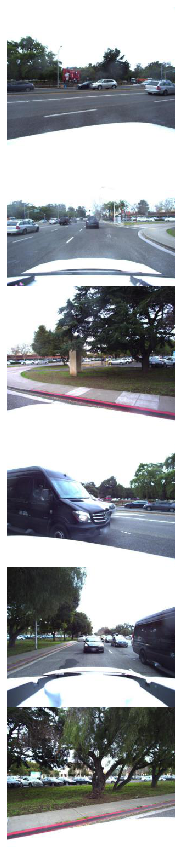

In [204]:
plt.figure(figsize=(3,18))
plt.imshow(torchvision.utils.make_grid(torch.stack(sample_cat)[0], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

# Define Sample

In [205]:
labeled_scene_index = np.arange(108, 134)

transform = torchvision.transforms.ToTensor()

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=15, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [206]:
sample_cat,sample, target, road_image, extra = iter(trainloader).next()

In [207]:
# road_image[0]

# Redo Plot draw_box

In [208]:
def draw_box(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    ax.plot(point_squence.T[0], point_squence.T[1], color=color)

# Range Plot

In [209]:
bounds = [(95, 25), (35, -35), (-25, -95), (155, 85), (-145, 145), (-85, -155)]
bounds_coef = [(math.tan(math.pi*(y1/180)), math.tan(math.pi*(y2/180))) for (y1, y2) in bounds]
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
camera_name = ['front_left', 'front', 'front_right', 'back_left', 'back', 'back_right']

In [220]:
def plot_range(sample_index):
    
    fig, ax = plt.subplots(nrows=6, ncols=2,figsize=(6,18))

    for i in range(6):
        ax[i, 0].imshow(torchvision.utils.make_grid(torch.stack(sample)[sample_index][i], nrow=3).numpy().transpose(1, 2, 0))
        ax[i, 0].axis('off')
        ax[i, 0].set_title(camera_name[i])
            
        ax[i, 1].imshow(road_image[sample_index], cmap='binary', extent=[-40,40,-40,40])
        
        if abs(bounds[i][0]) > 90: 
            x1 = np.arange(0, -40, -1)
        else:
            x1 = np.arange(0, 40)
            
        if abs(bounds[i][1]) > 90: 
            x2 = np.arange(0, -40, -1)
        else:
            x2 = np.arange(0, 40)

        ax[i, 1].scatter(0, 0, c = 'r', marker = 'x')

        y1 = bounds_coef[i][0] * x1
        y2 = bounds_coef[i][1] * x2
        
        
        ax[i, 1].plot(x1, y1, color = 'green', alpha = 0.5)
        ax[i, 1].plot(x2, y2, color = 'green', alpha = 0.5)
        
        if x1[1] == x2[1]:
            ax[i, 1].fill_between(x1, y1, y2, color = 'green', alpha = 0.5)
        else:
            ax[i, 1].fill_between(x1, y1, np.sign(y1[1])*40, color = 'green', alpha = 0.5)
            ax[i, 1].fill_between(x2, y2, np.sign(y2[1])*40, color = 'green', alpha = 0.5)
            
        
        ax[i, 1].set_xlim([-40, 40])
        ax[i, 1].set_ylim([-40, 40])
        ax[i, 1].grid()
        
        for j, bb in enumerate(target[sample_index]['bounding_box']):
            draw_box(ax[i, 1], bb, color=color_list[target[sample_index]['category'][j]]) 
            
    plt.savefig('camera_angels.jpg', dpi=300)
             
        

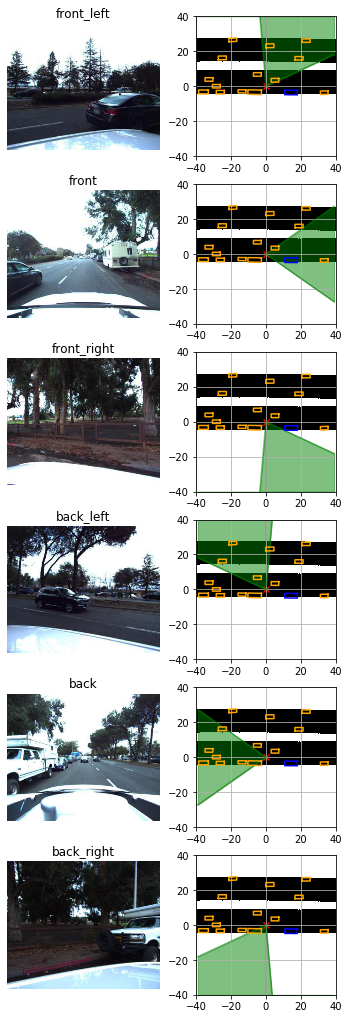

In [221]:
plot_range(0)

# Feature - Which Camera

In [ ]:
anno[anno['scene'] == 106][anno['sample'] == 0]

In [ ]:
bounds_quat = [[3,1], [1,4], [4,3], [2,1], [3,2], [4,3]]

In [ ]:
def check_cam_index(index, camera_index):
    points = [(anno.iloc[index, 4+i], anno.iloc[index, 8+i]) for i in range(4)]
#     print(np.sign(points))
    for x, y in points:
        
        if np.sign(x) == 1 and np.sign(y) == 1:
            quat = 1
        elif np.sign(x) == 1 and np.sign(y) == -1:
            quat = 4
        elif np.sign(x) == -1 and np.sign(y) == 1:
            quat = 2
        else:
            quat = 3
            
        if quat not in bounds_quat[camera_index]:
            continue
            
        angle = math.atan(y/x)/math.pi*180
        
        if quat in [1,2] and angle < 0:
            angle += 180
        elif quat in [3,4] and angle > 0:
            angle -= 180
        
        if camera_index == 4:
            if abs(angle) > 145:
                return True
        else:
            if angle >= min(bounds[camera_index]) and angle <= max(bounds[camera_index]):
                return True
            
    
    return False

In [ ]:
def check_cam_row(row, camera_index):
    points = [(row.iloc[4+i], row.iloc[8+i]) for i in range(4)]
#     print(np.sign(points))
    for x, y in points:
        
        if np.sign(x) == 1 and np.sign(y) == 1:
            quat = 1
        elif np.sign(x) == 1 and np.sign(y) == -1:
            quat = 4
        elif np.sign(x) == -1 and np.sign(y) == 1:
            quat = 2
        else:
            quat = 3
            
        if quat not in bounds_quat[camera_index]:
            continue
            
        angle = math.atan(y/x)/math.pi*180
        
        if quat in [1,2] and angle < 0:
            angle += 180
        elif quat in [3,4] and angle > 0:
            angle -= 180
        
        if camera_index == 4:
            if abs(angle) > 145:
                return True
        else:
            if angle >= min(bounds[camera_index]) and angle <= max(bounds[camera_index]):
                return True
            
    
    return False

In [ ]:
for index, name in enumerate(camera_name):
    anno[name] = anno.apply(lambda x: check_cam_row(x, index), axis = 1)

In [ ]:
anno.head()

# Feature - Distance

In [ ]:
def get_distance(row):
    x = np.mean(row.iloc[4:8])
    y = np.mean(row.iloc[8:12])
    return np.sqrt(x**2 + y**2)

In [ ]:
anno['distance'] = anno.apply(lambda x: get_distance(x), axis = 1)

In [ ]:
anno.head()

In [ ]:
idx = [i for i in range(road_image[0].size(0) -1, -1, -1)]
idx = torch.LongTensor(idx)
inverted_roadimage = road_image[0].index_select(0, idx)

In [ ]:
road_image[0]

# Look at COCO annotation

In [ ]:
import json

In [ ]:
# Reading the json as a dict
with open('instances_val2017.json') as json_data:
    data = json.load(json_data)

# using the from_dict load function. Note that the 'orient' parameter 
#is not using the default value (or it will give the same error than you had)
# We transpose the resulting df and set index column as its index to get this result
# pd.DataFrame.from_dict(data, orient='index').T.set_index('index')   

In [ ]:
# data

# Try Concat Images

In [ ]:
a = torch.rand(6, 3, 10, 20)
# b = torch.rand(6, 3, 10, 20)

In [ ]:
a.shape

In [ ]:
c = torch.cat((a, b), 1)
c.shape

In [ ]:
labeled_scene_index = np.arange(106,108)

transform = torchvision.transforms.ToTensor()

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)


In [ ]:
sample_cat, sample, target, road_image, extra = iter(trainloader).next()

In [ ]:
print(torch.stack(sample_cat).shape)

# Try tqdm

In [ ]:
from tqdm.autonotebook import tqdm

In [ ]:
progress_bar = tqdm(trainloader)
for iter, data in enumerate(progress_bar):
    print(iter)
    sample_cat, sample, target, road_image, extra = data
    print(torch.stack(sample_cat).shape)
    break

In [ ]:
trainloader

# Feature - weight/height/centerx/centery style annotation

In [ ]:
def get_whxy(row):
    x = np.mean(row.iloc[4:8])
    y = np.mean(row.iloc[8:12])
    w = abs(max(row.iloc[4:8]) - min(row.iloc[4:8]))
    h = abs(max(row.iloc[8:12]) - min(row.iloc[8:12]))
    return np.array([x, y, w, h])

In [ ]:
anno['center_x'], anno['center_y'], anno['box_width'], anno['box_height'] = np.array(anno.apply(lambda x: get_whxy(x), axis = 1).tolist()).T

In [ ]:
anno.head()

# Try CV2 Read Image

In [ ]:
import cv2

In [ ]:
img = cv2.imread('/Users/mjin/Desktop/1008/Project/DeepLearning2020/datasets/dl2020/scene_106/sample_0/CAM_BACK_LEFT.jpeg')

In [ ]:
type(img)

In [ ]:
image_names = [
    'CAM_FRONT_LEFT.jpeg',
    'CAM_FRONT.jpeg',
    'CAM_FRONT_RIGHT.jpeg',
    'CAM_BACK_LEFT.jpeg',
    'CAM_BACK.jpeg',
    'CAM_BACK_RIGHT.jpeg',
    ]

In [ ]:
images = []
image_cat = []
for image_name in image_names:
    image_path = '/Users/mjin/Desktop/1008/Project/DeepLearning2020/datasets/dl2020/scene_106/sample_0/CAM_BACK_LEFT.jpeg'
    image = cv2.imread(image_path)
    if len(image_cat) < 1:
        image_cat = image
    else:
        image_cat = np.concatenate((image_cat, image), axis=0)
    images.append(image)

In [ ]:
image_cat.shape

# Try new data loader

In [4]:
from data_helper import LabeledDataset_coco, Resizer, Normalizer, Augmenter, collater
from torchvision import transforms

In [5]:
labeled_scene_index = np.arange(107, 134)

transform = transforms.Compose([Normalizer(mean=params.mean, std=params.std),\
                                    Augmenter(),\
                                    Resizer(input_sizes[opt.compound_coef])])

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=15, shuffle=False, num_workers=0, collate_fn=collate_fn)

NameError: name 'params' is not defined

In [18]:
for i, j in anno.iterrows():
    print(j['center_x'])
    break

-11.991556941178976


In [35]:
anno.sort_values(by = ['scene', 'sample']).head()

,Unnamed: 0,scene,sample,action,category,fl_x,fr_x,bl_x,br_x,fl_y,...,front,front_right,back_left,back,back_right,distance,center_x,center_y,box_width,box_height
3583,3583,106,0,object_action_parked,other_vehicle,4.967384,4.899423,-1.740261,-1.808222,-1.798935,...,True,True,False,False,True,3.400402,1.579581,-3.011255,6.775606,2.773454
3584,3584,106,0,object_action_parked,other_vehicle,23.381680,23.408801,12.827323,12.854444,-1.698497,...,True,False,False,False,False,18.379832,18.118062,-3.090964,10.581478,2.784935
3585,3585,106,0,object_action_driving_straight_forward,car,-10.379461,-10.388055,-6.546532,-6.555126,21.758967,...,False,False,True,False,False,24.311025,-8.467294,22.788832,3.841523,2.059730
3586,3586,106,0,object_action_parked,car,16.455485,16.451223,21.452425,21.448162,25.477589,...,False,False,False,False,False,32.538411,18.951824,26.449509,5.001202,1.943841
3587,3587,106,0,object_action_parked,car,-37.043864,-37.048009,-32.708916,-32.713061,25.781453,...,False,False,True,True,False,43.940782,-34.878463,26.726113,4.339093,1.889320


In [34]:
anno.columns

Index(['Unnamed: 0', 'scene', 'sample', 'action', 'category', 'fl_x', 'fr_x',
       'bl_x', 'br_x', 'fl_y', 'fr_y', 'bl_y', 'br_y', 'category_id',
       'action_id', 'new_scene', 'front_left', 'front', 'front_right',
       'back_left', 'back', 'back_right', 'distance', 'center_x', 'center_y',
       'box_width', 'box_height'],
      dtype='object')

# Plot scaled boxes

In [5]:
example = anno[anno['scene'] == 106][anno['sample'] ==0]

/Users/mjin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [14]:
example.head()

,Unnamed: 0,scene,sample,action,category,fl_x,fr_x,bl_x,br_x,fl_y,...,back_right,distance,center_x,center_y,box_width,box_height,scaled_x,scaled_y,scaled_box_width,scaled_box_height
3583,3583,106,0,object_action_parked,other_vehicle,4.967384,4.899423,-1.740261,-1.808222,-1.798935,...,True,3.400402,1.579581,-3.011255,6.775606,2.773454,292.167105,399.595468,51.833382,26.625158
3584,3584,106,0,object_action_parked,other_vehicle,23.381680,23.408801,12.827323,12.854444,-1.698497,...,False,18.379832,18.118062,-3.090964,10.581478,2.784935,404.129022,400.305572,80.948304,26.735371
3585,3585,106,0,object_action_driving_straight_forward,car,-10.379461,-10.388055,-6.546532,-6.555126,21.758967,...,False,24.311025,-8.467294,22.788832,3.841523,2.059730,226.531376,155.340504,29.387655,19.773409
3586,3586,106,0,object_action_parked,car,16.455485,16.451223,21.452425,21.448162,25.477589,...,False,32.538411,18.951824,26.449509,5.001202,1.943841,431.851853,120.754275,38.259195,18.660871
3587,3587,106,0,object_action_parked,car,-37.043864,-37.048009,-32.708916,-32.713061,25.781453,...,False,43.940782,-34.878463,26.726113,4.339093,1.889320,22.582730,118.360576,33.194062,18.137473


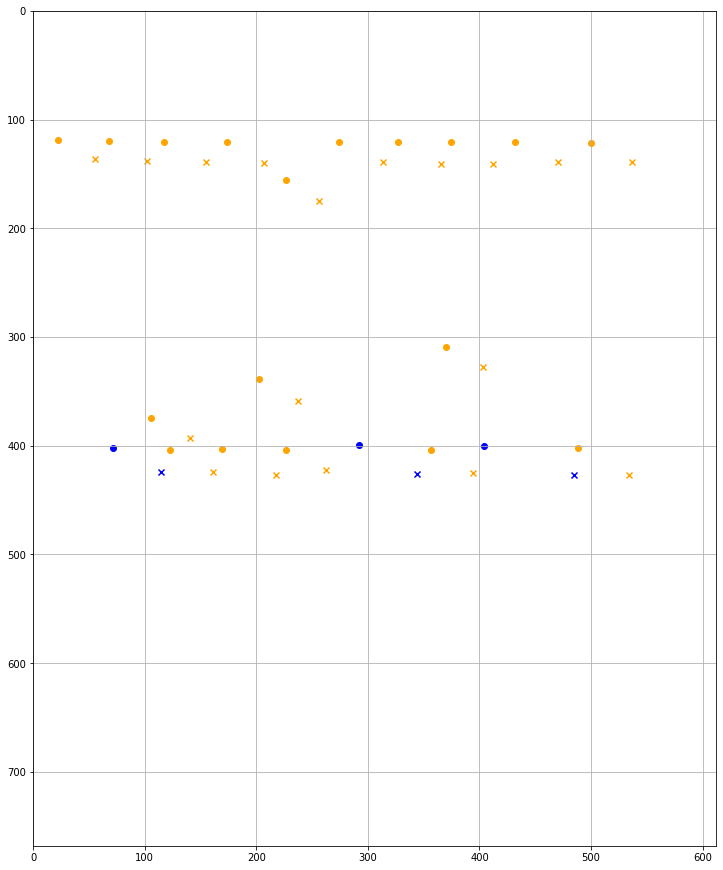

In [16]:
plt.figure(figsize = (6.12*2,7.68*2))
plt.xlim(0, 612)
plt.ylim(768, 0)
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

for i, row in example.iterrows():
    plt.scatter(row['scaled_x'], row['scaled_y'], color = color_list[row['category_id']])
    plt.scatter(row['scaled_x'] + row['scaled_box_width'], row['scaled_y'] + row['scaled_box_height'], color = color_list[row['category_id']], marker = 'x')
    
plt.grid()


plt.show()

In [49]:
a = None

In [52]:
a is not None

False

In [96]:
a = torch.rand(6, 3, 200, 300)

In [55]:
a.shape

torch.Size([3, 200, 300])

In [86]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [82]:
tensor_mean = torch.Tensor(3, 200, 300)
tensor_std = torch.Tensor(3, 200, 300)

In [87]:
for i in range(3):
    tensor_mean[i].fill_(mean[i])
    tensor_std[i].fill_(std[i])

In [91]:
b = (a - tensor_mean) / tensor_std

In [92]:
b.shape

torch.Size([3, 200, 300])

In [95]:
class Normalizer_test(object):

    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.tensor_mean = torch.Tensor(3, 200, 300)
        self.tensor_std = torch.Tensor(3, 200, 300)
        
        for i in range(3):
            self.tensor_mean[i].fill_(mean[i])
            self.tensor_std[i].fill_(std[i])

    def __call__(self, sample):
        sample = (sample - 255 - self.tensor_mean)/self.tensor_std
        return sample


In [143]:
a = torch.rand(1, 6, 3, 200, 300)

In [137]:
a = a[0].permute(0, 2, 3, 1)

In [138]:
a = a.numpy()

In [139]:
image_front = []
image_back = []

for i, image in enumerate(a):
    if i <= 2:
        if len(image_front) < 1:
            image_front = image
        else:
            image_front = np.concatenate((image_front, image), axis=0)
    else:
        if len(image_back) < 1:
            image_back = image
        else:
            image_back = np.concatenate((image_back, image), axis=0)

sample = np.concatenate((image_back, image_front), axis=1)

In [142]:
image_back.shape

(600, 300, 3)

In [149]:
import cv2

In [150]:
a = torch.rand(1, 6, 3, 200, 300)

In [151]:
def aspectaware_resize_padding(image, width, height, interpolation=None, means=None):

    old_h, old_w, c = image.shape
    if old_w > old_h:
        new_w = width
        new_h = int(width / old_w * old_h)
    else:
        new_w = int(height / old_h * old_w)
        new_h = height

    canvas = np.zeros((height, height, c), np.float32)
    if means is not None:
        canvas[...] = means

    if new_w != old_w or new_h != old_h:
        if interpolation is None:
            image = cv2.resize(image, (new_w, new_h))
        else:
            image = cv2.resize(image, (new_w, new_h), interpolation=interpolation)

    padding_h = height - new_h
    padding_w = width - new_w

    if c > 1:
        canvas[:new_h, :new_w] = image
    else:
        if len(image.shape) == 2:
            canvas[:new_h, :new_w, 0] = image
        else:
            canvas[:new_h, :new_w] = image

    return [canvas, new_w, new_h, old_w, old_h, padding_w, padding_h]

In [152]:
def preprocess_test(sample, max_size=512):
    # Load original images in a list
    ori_imgs = []
    sample = sample[0].permute(0, 2, 3, 1).numpy()

    image_front = []
    image_back = []

    for i, image in enumerate(sample):
        if i <= 2:
            if len(image_front) < 1:
                image_front = image
            else:
                image_front = np.concatenate((image_front, image), axis=0)
        else:
            if len(image_back) < 1:
                image_back = image
            else:
                image_back = np.concatenate((image_back, image), axis=0)

    sample = np.concatenate((image_back, image_front), axis=1)

    sample_lst = aspectaware_resize_padding(sample[::-1], max_size, max_size, means=None)

    framed_img = sample_lst[0]

    framed_meta = sample_lst[1]

    return sample, framed_img, framed_meta

In [154]:
ori_sample, framed_img, framed_meta = preprocess_test(a)

In [155]:
sample = torch.from_numpy(framed_img)

In [156]:
sample = sample.unsqueeze(0).permute(0, 3, 1, 2)

In [157]:
sample.shape

torch.Size([1, 3, 512, 512])

In [178]:
from PIL import Image
import cv2
import torch

In [166]:
img_path = '/Users/mjin/Desktop/1008/Project/data/scene_37/sample_0/CAM_BACK_LEFT.jpeg'

In [173]:
img_1 = Image.open(img_path)

In [169]:
img_2 = cv2.imread(img_path)

In [174]:
transform = torchvision.transforms.ToTensor()

In [175]:
img_1 = transform(image)

In [171]:
img_2.shape

(256, 306, 3)

In [176]:
img_1.shape

torch.Size([3, 256, 306])

In [180]:
img_1

tensor([[[0.0784, 0.0784, 0.0784,  ..., 0.5294, 0.4980, 0.4980],
         [0.0784, 0.0784, 0.0745,  ..., 0.5373, 0.5059, 0.5059],
         [0.0784, 0.0745, 0.0745,  ..., 0.5255, 0.5137, 0.5059],
         ...,
         [0.6000, 0.6039, 0.6039,  ..., 0.9922, 0.9098, 0.8980],
         [0.6000, 0.6000, 0.6039,  ..., 0.9922, 1.0000, 1.0000],
         [0.6000, 0.6000, 0.6039,  ..., 1.0000, 0.9961, 0.9961]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.3569, 0.3294, 0.3333],
         [0.0588, 0.0588, 0.0549,  ..., 0.3608, 0.3373, 0.3412],
         [0.0588, 0.0549, 0.0549,  ..., 0.3490, 0.3451, 0.3490],
         ...,
         [0.5451, 0.5490, 0.5490,  ..., 0.9608, 0.8392, 0.8157],
         [0.5490, 0.5490, 0.5529,  ..., 0.9765, 1.0000, 0.9961],
         [0.5490, 0.5490, 0.5529,  ..., 1.0000, 0.9882, 0.9882]],

        [[0.0667, 0.0667, 0.0667,  ..., 0.6824, 0.6471, 0.6392],
         [0.0667, 0.0667, 0.0627,  ..., 0.6980, 0.6549, 0.6471],
         [0.0667, 0.0627, 0.0627,  ..., 0.6863, 0.6627, 0.